<a href="https://colab.research.google.com/github/LuckerZOfficiaL/A-Contrastive-Learning-Approach-for-Finger-Photo-Identification/blob/main/Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install import-ipynb
import import_ipynb
from google.colab import drive
from google.colab.patches import cv2_imshow
import numpy as np
import os
import random
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

drive_path = '/content/drive'
drive.mount(drive_path)

%cd /content/drive/MyDrive/Sapienza/Y1/Biometric Systems/Shared Project Folder/Code
from Architecture import ResnetClassifier
%cd /content/drive/MyDrive/Sapienza/Y1/Biometric Systems/Shared Project Folder

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1fz0aq2n-SyUbVYiAvJLNUhWeDGqsiVmb/Sapienza/Y1/Biometric Systems/Shared Project Folder/Code
/content/drive/.shortcut-targets-by-id/1fz0aq2n-SyUbVYiAvJLNUhWeDGqsiVmb/Sapienza/Y1/Biometric Systems/Shared Project Folder


#Test Dataset
The dataset contains 192 preprocessed finger photos. There are 24 distinct fingers each with 8 photos.

In [ ]:
test_root_path = './Datasets/5. Thresholded-Then-Thinned-Test'
test_items = os.listdir(test_root_path)
test_items = sorted(test_items)

len(test_items)

192

Let's see one image

60_o_2_w_4.JPG (295, 170)


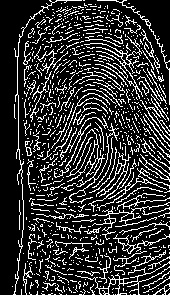

In [ ]:
idx = 123
img = cv2.imread(test_root_path+"/"+test_items[idx], cv2.IMREAD_GRAYSCALE)


print(test_items[idx], img.shape)
cv2_imshow(img)

# Evaluation Setting
We adopt the **all-against-all** approach, where we compute the distance of all images against all others.

Hence, we first compute this 192x192 matrix where the entry (i,j) contains the distance between image i and image j.

In [ ]:
def create_gallery(folder_path, items):
  #items = os.listdir(test_folder_path)
  test_id_list = []
  test_imgs = []

  for item in items:
      image_path = os.path.join(folder_path, item)
      image = Image.open(image_path).convert("L")
      image = np.array(image)
      image = torch.tensor(image)
      test_imgs.append(image)
      finger_id = int(item.split("_")[0]) * int(item.split("_")[2])
      test_id_list.append(finger_id)


  test_imgs = torch.stack(test_imgs)
  test_imgs = test_imgs.unsqueeze(1)
  test_ids = torch.tensor(test_id_list)

  return test_imgs, test_ids

In [ ]:
whole_gallery, all_ids = create_gallery(test_root_path, test_items)

whole_gallery = whole_gallery.to("cuda").float()
whole_gallery.shape

torch.Size([192, 1, 295, 170])

In [ ]:
all_ids # non serve

tensor([ 53,  53,  53,  53,  53,  53,  53,  53, 106, 106, 106, 106, 106, 106,
        106, 106,  54,  54,  54,  54,  54,  54,  54,  54, 108, 108, 108, 108,
        108, 108, 108, 108,  55,  55,  55,  55,  55,  55,  55,  55, 110, 110,
        110, 110, 110, 110, 110, 110,  56,  56,  56,  56,  56,  56,  56,  56,
        112, 112, 112, 112, 112, 112, 112, 112,  57,  57,  57,  57,  57,  57,
         57,  57, 114, 114, 114, 114, 114, 114, 114, 114,  58,  58,  58,  58,
         58,  58,  58,  58, 116, 116, 116, 116, 116, 116, 116, 116,  59,  59,
         59,  59,  59,  59,  59,  59, 118, 118, 118, 118, 118, 118, 118, 118,
         60,  60,  60,  60,  60,  60,  60,  60, 120, 120, 120, 120, 120, 120,
        120, 120,  61,  61,  61,  61,  61,  61,  61,  61, 122, 122, 122, 122,
        122, 122, 122, 122,  62,  62,  62,  62,  62,  62,  62,  62, 124, 124,
        124, 124, 124, 124, 124, 124,  63,  63,  63,  63,  63,  63,  63,  63,
        126, 126, 126, 126, 126, 126, 126, 126,  64,  64,  64,  

## Import Model

In [ ]:
model = ResnetClassifier(num_classes=128, hidden_size=128, initialize="xavier")
model_path = "./Code/Models/resnetSimCLR_128hidden.pth"

#model = ResnetClassifier(num_classes=128, hidden_size=512, initialize="xavier")
#model_path = "./Code/Models/resnetSimCLR_512hidden.pth"


model.to(torch.device('cuda'))
model.load_state_dict(torch.load(model_path))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [ ]:
output = model.forward_projector(whole_gallery)
output.shape

torch.Size([192, 128])

## Distance/Similarity Visualization

### Euclidean Distance

In [ ]:
def get_distance_matrix(embs, d="euclidean"):
  if d == "euclidean":
    return torch.cdist(embs, embs, p=2.0)
  if d == "cosine":
    embs_normalized = F.normalize(embs, p=2, dim=1)
    return torch.mm(embs_normalized, embs_normalized.T)

In [ ]:
eu_all_against_all = get_distance_matrix(output, d="euclidean")
eu_all_against_all.shape

torch.Size([192, 192])

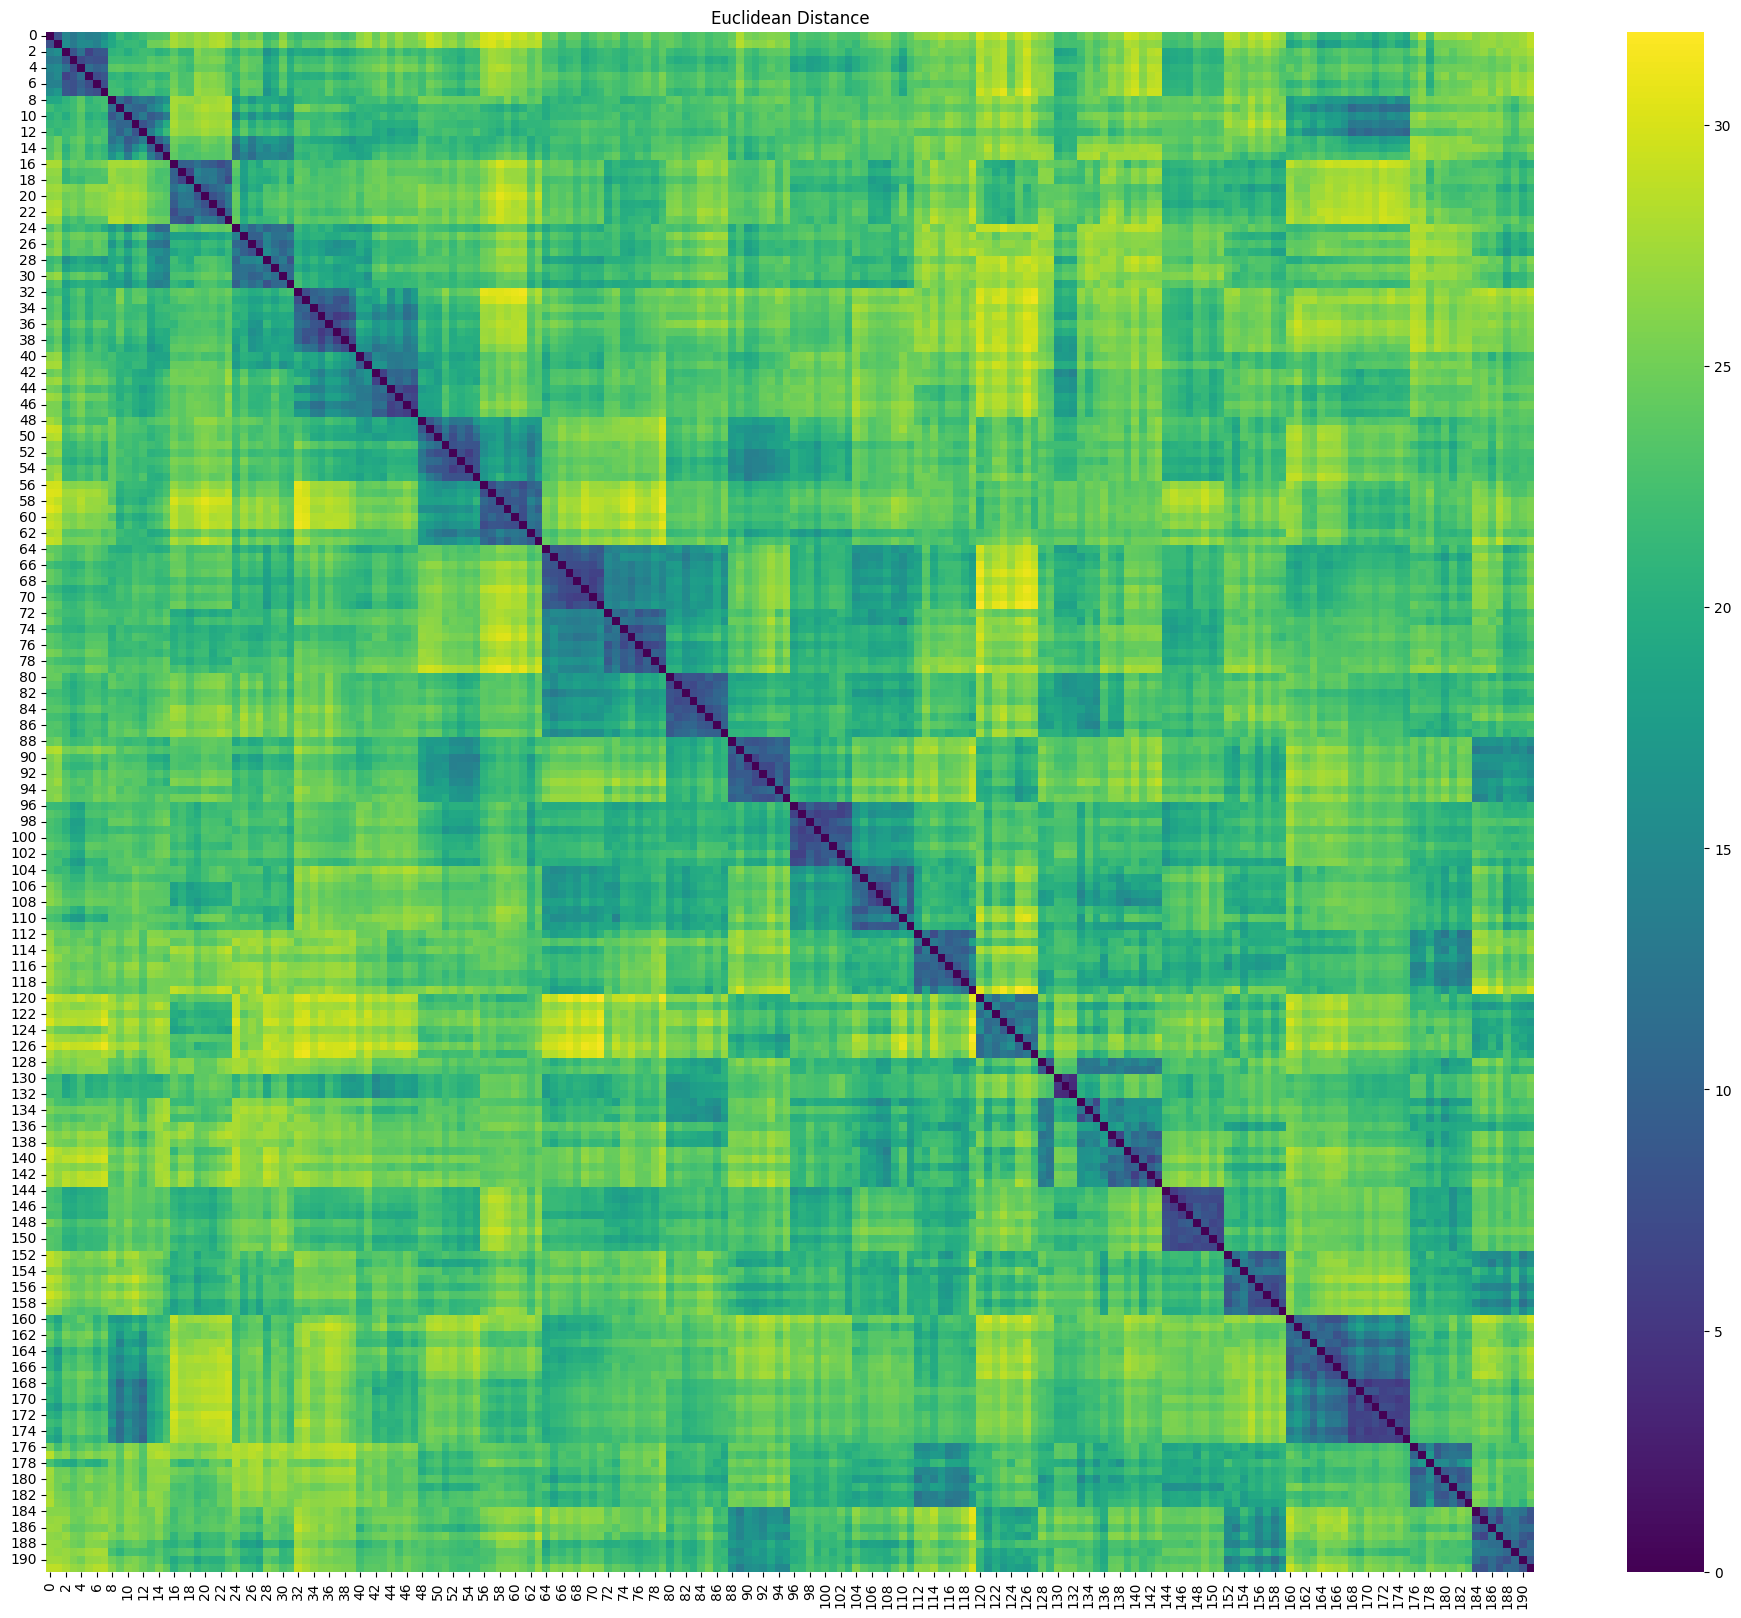

In [ ]:
plt.figure(figsize=(24,20))
sns.heatmap(eu_all_against_all.detach().cpu().numpy(), cmap='viridis')
plt.title('Euclidean Distance')
plt.show()

### Cosine Similarity

In [ ]:
cos_all_against_all = get_distance_matrix(output, d="cosine")
cos_all_against_all.shape

torch.Size([192, 192])

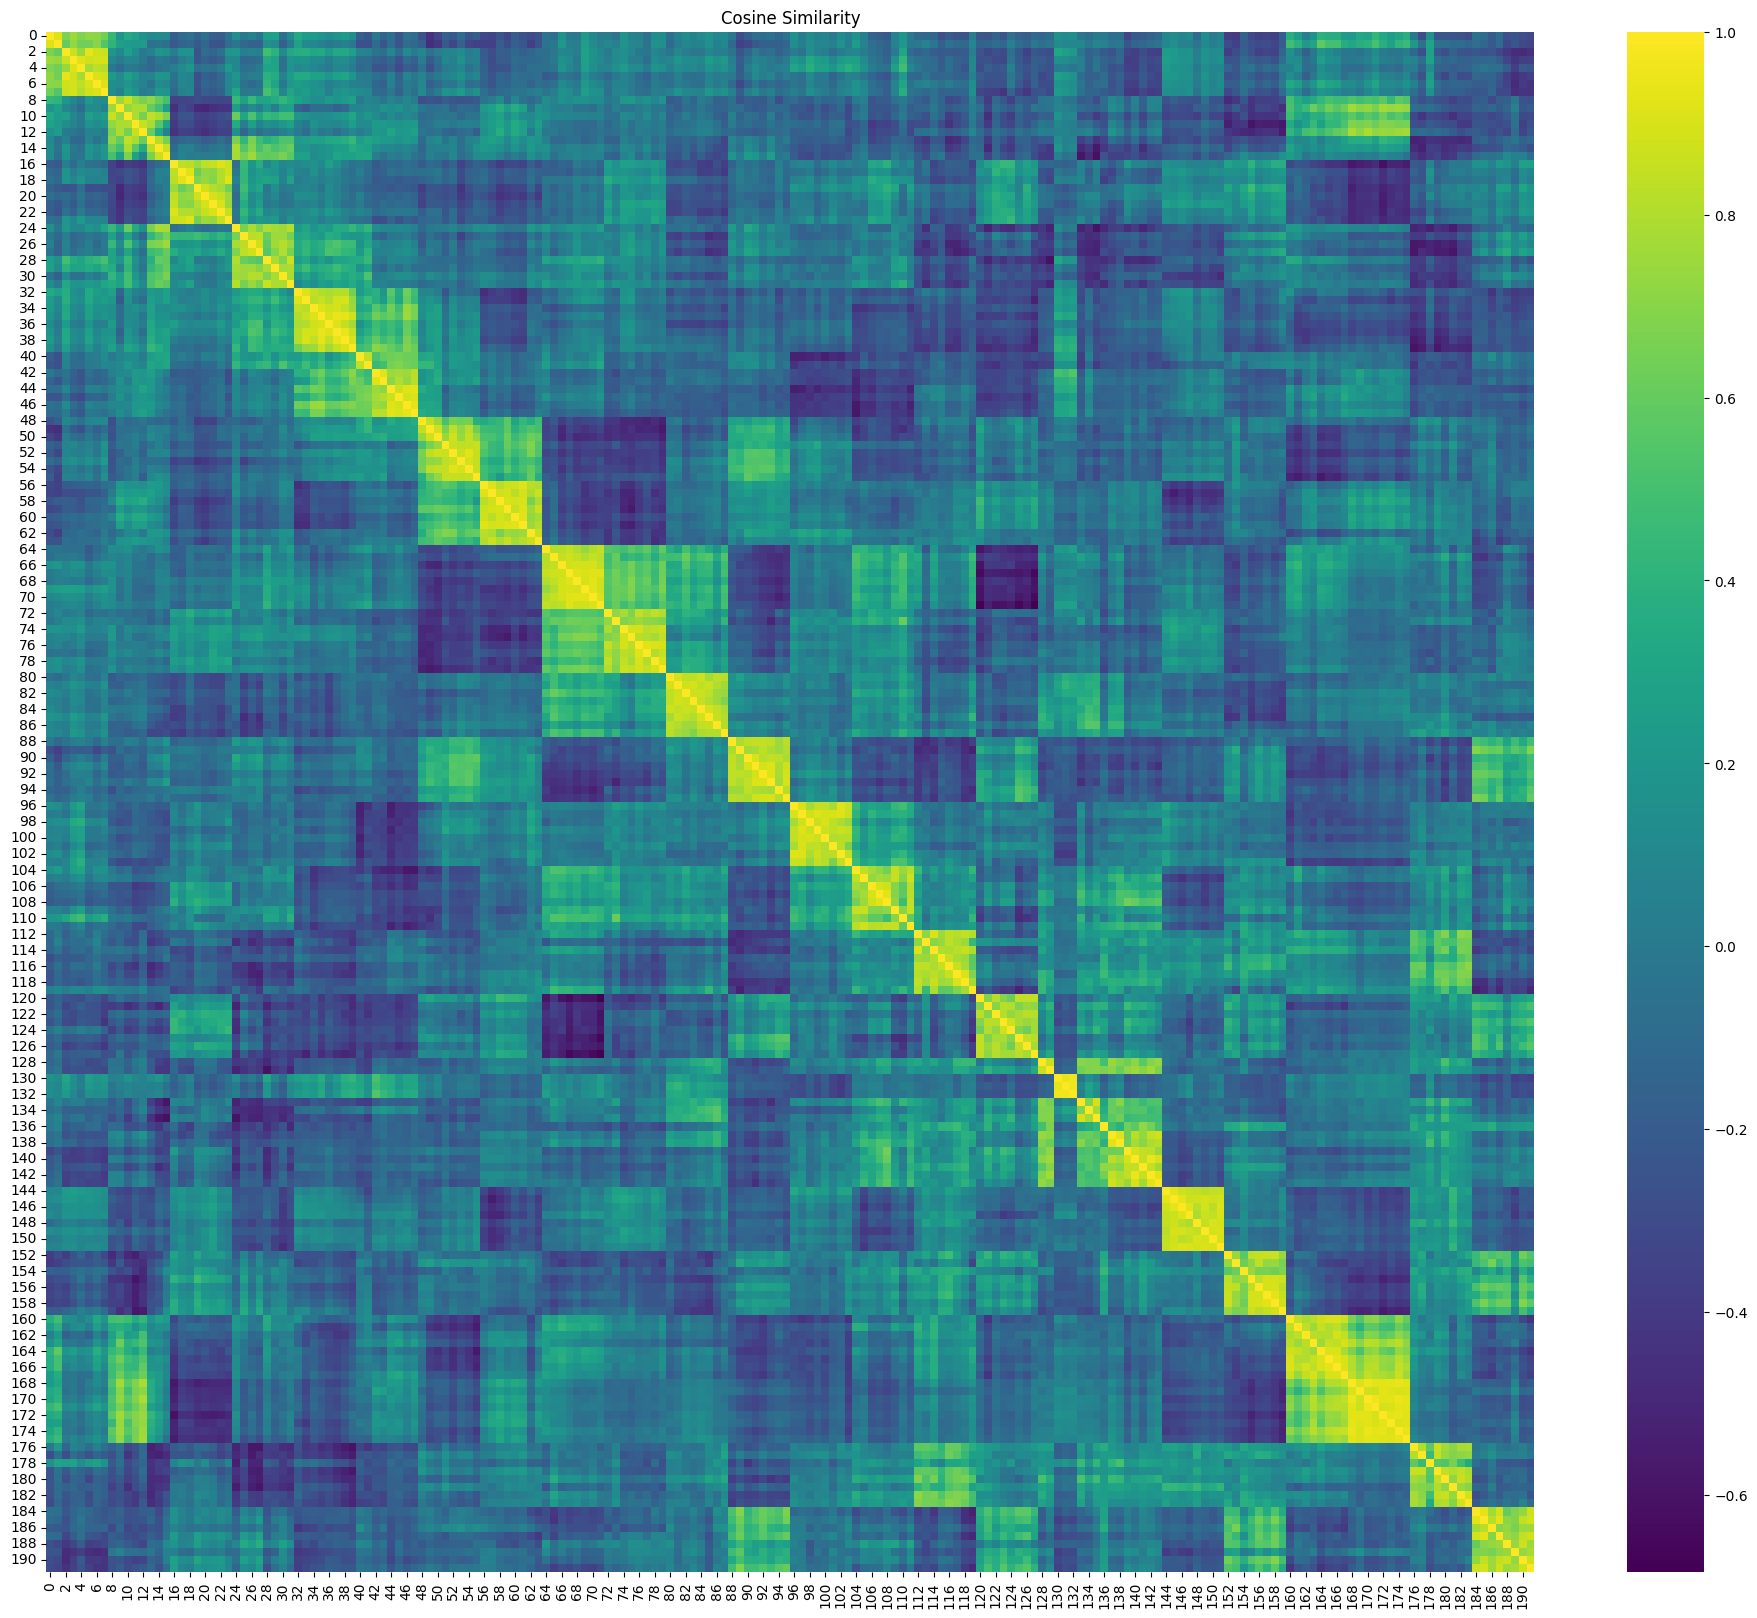

In [ ]:
plt.figure(figsize=(24,20))
sns.heatmap(cos_all_against_all.detach().cpu().numpy(), cmap='viridis')
plt.title('Cosine Similarity')
plt.show()

# Metrics

## Top-1 Matching performance
For each row, we assume it's a probe and compare it against all others. If the best match is against an image of the same figer ID, then it's a correct response.

### Euclidean Distance

In [ ]:
correct = 0
wrong = 0

for i, row in enumerate(eu_all_against_all):
  square_start_idx = (i//8)*8  # this is the starting index of the 8x8 square where the ith finger photo belongs, if the best score is within this square, it's correct!
  square_end_idx = square_start_idx + 8 # this is the ending index of the square

  sorted_indices  = torch.argsort(row, descending=False)
  argmin_index = sorted_indices[1] # second because the first is obviously itself!

  if square_start_idx <= argmin_index < square_end_idx:
    correct += 1
  else: wrong += 1

correct, wrong

(192, 0)

### Cosine Similarity

In [ ]:
correct = 0
wrong = 0

for i, row in enumerate(cos_all_against_all):
  square_start_idx = (i//8)*8  # this is the starting index of the 8x8 square where the ith finger photo belongs, if the best score is within this square, it's correct!
  square_end_idx = square_start_idx + 8 # this is the ending index of the square

  sorted_indices  = torch.argsort(row, descending=True)
  argmax_index = sorted_indices[1] # second because the first is obviously itself!

  if square_start_idx <= argmax_index < square_end_idx:
    correct += 1
  else: wrong += 1

correct, wrong

(192, 0)

### Top-k Performance
For a generic k in range [1, 7], let's see if the k-th best score is still achieved by a correct template. If even the 7th score is higher than other templates, then baaam!

In [ ]:
# Into a function

def get_performance(all_against_all, rank=1, d="euclidean"):
  correct = 0

  for i, row in enumerate(all_against_all):
    square_start_idx = (i//8)*8  # this is the starting index of the 8x8 square where the ith finger photo belongs, if the best score is within this square, it's correct!
    square_end_idx = square_start_idx + 8 # this is the ending index of the square

    if d=="euclidean":
      sorted_indices  = torch.argsort(row, descending=False)
    else:
      sorted_indices  = torch.argsort(row, descending=True)

    target_index = sorted_indices[rank] # this argmin_index already neglects the probe image itself, no worries

    if square_start_idx <= target_index < square_end_idx:
      correct += 1

  return correct, len(all_against_all)-correct, correct/len(all_against_all) # returns the correct, wrong, and identification rate

In [ ]:
get_performance(eu_all_against_all, rank=3, d="euclidean")

(185, 7, 0.9635416666666666)

In [ ]:
get_performance(cos_all_against_all, rank=3, d="cosine")

(183, 9, 0.953125)

In [ ]:
eu_identification_probs = []
cos_identification_probs = []

for k in range(1, 8):
  _, _, identification_prob = get_performance(eu_all_against_all, rank=k, d="euclidean")
  eu_identification_probs.append(identification_prob)

  _, _, identification_prob = get_performance(cos_all_against_all, rank=k, d="cosine")
  cos_identification_probs.append(identification_prob)

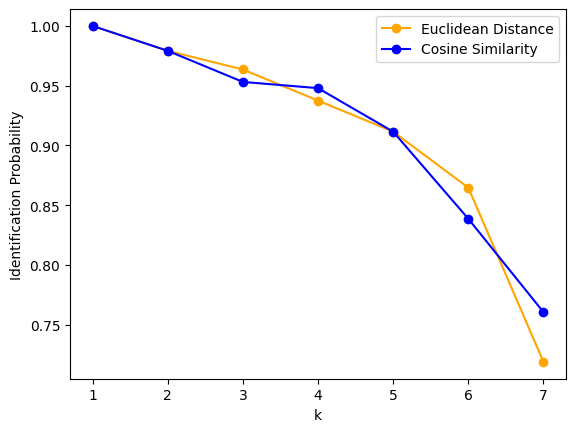

In [ ]:
# Plot the lists on a line chart
x_values = range(1, len(eu_identification_probs) + 1) # this is because I want the x-axis to start from 1, not 0!

plt.plot(x_values, eu_identification_probs, label='Euclidean Distance', color='orange', marker="o")
plt.plot(x_values, cos_identification_probs, label='Cosine Similarity', color='blue', marker="o")

plt.xlabel('k')
plt.ylabel('Identification Probability')
plt.legend()
plt.show()

So, the model seems pretty astounding! Even the 7th best-scoring template is a correct template in most cases (70%+).

# Random Galleries Partition

Vi spiego qui.

\
Noi abbiamo 192 esempi di foto per fare l'evaluation. In questi 192, ci sono 8 foto per ogni dito, e sono 24 dita. Infatti, 8 x 24 = 192.

\
Ho usato il modello per calcolare le distanza tra tutte le coppie, generando una matrice 192x192 dove il valore in (i, j) indica la distanza tra foto i e foto j. Ovviamente sulla diagonale abbiamo score massimi.

\
La matrice è fatta in modo che 8 indici contigui sono dello stesso dito. Ossia, le prime 8 righe della matrice corrispondono alle prime 8 foto, tutte dello stesso dito. Da 9 a 16, sono tutte foto del secondo dito, eccetera.

\
\
Questa è la matrice. Come vedete, la diagonale ha distanza 0, perchè la distanza con se stessa è 0. Ma anche nel blocco intorno abbiamo distanze piccole, e infatti sono altri tempalte dello stesso dito.

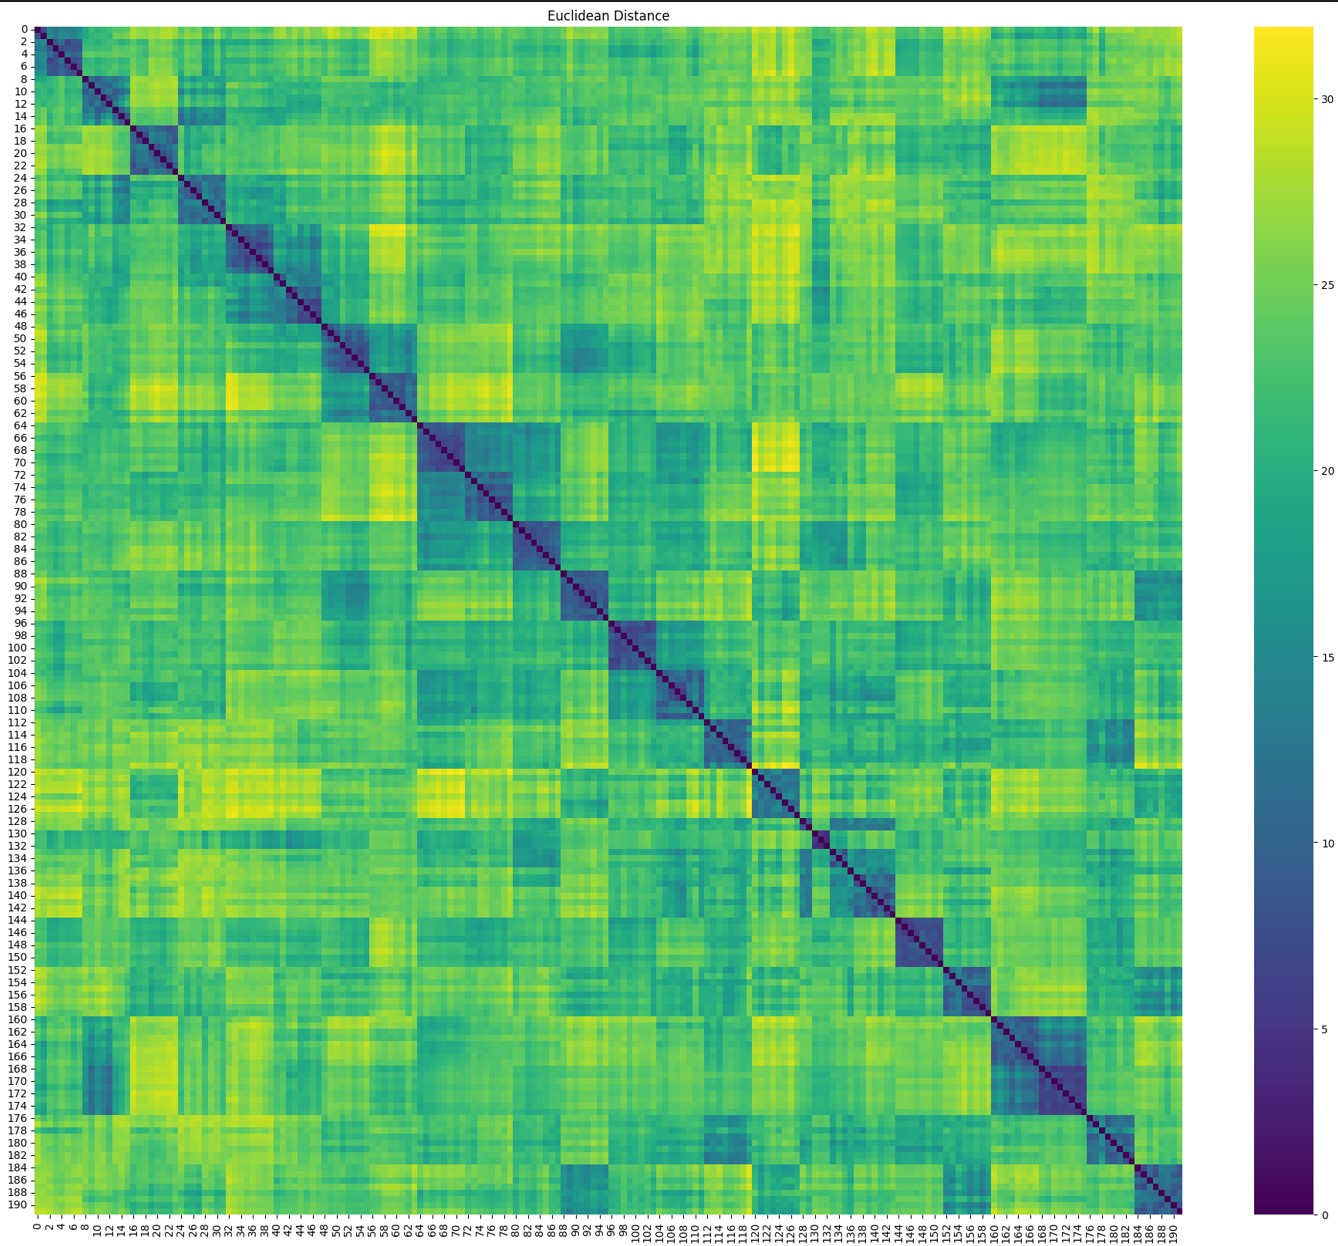

Quello che dovete fare è creare partizioni randomiche di questa matrice e fare evaluation su quelle partizioni.

\
Perchè?
perchè ogni partizione simula uno use case di galleria.

\
Creare partizioni significa randomicamente scegliere delle righe e delle colonne da questa matrice. Ogni riga corrisponde ad una probe, e le colonne corrispondono ad una galleria.

\
Per ogni simulazione, dovete vedere se la distanza minima tra le vostre probe (righe) e la galleria (colonne) è un template dello stesso dito. Se si, vale come identificazione corretta.

\
Simulate più volte e riportate i risultati.

In [ ]:
# Ecco qui la vostra matrice
all_matrix = eu_all_against_all.detach().cpu()
all_matrix.shape

torch.Size([192, 192])

### Example

In [ ]:
probe_index = 25 # assume probe is index 25
best_score_index = torch.argsort(all_matrix[probe_index])[1]  # get the index of the best match (except from itself)

In [ ]:
# Calculate the interval of correct match, the 8x8 square
range_lower = (probe_index//8)*8 #24
range_upper = range_lower + 8 #32

In [ ]:
# is the best score index inside this square?
if best_score_index in range(range_lower, range_upper):
  print("identification correct!")
else: print("identification wrong...")

identification correct!


# Gallery Simulations

In [ ]:
def get_cms(all_matrix, num_probes=20, num_positives_for_probe=2, num_negatives=80):

  correct_rank = [0]*7

  # list of index of choosen probs
  population = list(range(192))  # Numbers from 0 to 191
  probe_indexes = random.sample(population, num_probes)

  columns_to_skip = probe_indexes.copy()
  columns_positive_to_have = []
  columns_negative_to_have = []

  for probe_index in probe_indexes:
    range_lower = (probe_index//8) * 8  # start of the significant square
    range_upper = range_lower + 8   # end of the square
    this_positive_colums_to_have = [] # this will contain the positive colums for this current probe
    for _ in range(num_positives_for_probe): # we add a few positives
      # right matching for the probe
      positive_index = random.randint(range_lower, range_upper-1)
      while (positive_index in this_positive_colums_to_have):
        positive_index = random.randint(range_lower, range_upper-1)
      this_positive_colums_to_have.append(positive_index)

    columns_positive_to_have.extend(this_positive_colums_to_have)
    seen_set = set()
    unique_list = [element for element in columns_positive_to_have if not (element in seen_set or seen_set.add(element))] # this removes duplicate colums positive to have
    columns_positive_to_have = unique_list

  columns_to_skip.extend(columns_positive_to_have) # we now add the rest, and we skip all the positives added

  columns_negative_to_have.extend(np.random.permutation(
      np.setdiff1d(np.arange(191), columns_to_skip))[:num_negatives])

  for probe_index in probe_indexes:
    range_lower = (probe_index//8) * 8
    range_upper = range_lower + 8

    # column indexes sorted by the distance with the probe
    sorted_indexes = list(np.argsort(all_matrix[probe_index]).numpy())
    sorted_indexes_only_this_gallery = [value for value in sorted_indexes if (value in columns_positive_to_have) or (value in columns_negative_to_have)] # this list containst ordered elements of sorted_indexes but only those that are in our current gallery
    for i in range(7):
      if any(idx in range(range_lower, range_upper) for idx in sorted_indexes_only_this_gallery[:i+1]):
          correct_rank[i] += 1

  return [i/num_probes for i in correct_rank]

In [ ]:
get_cms(all_matrix, num_probes=20, num_positives_for_probe=2, num_negatives=120)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [ ]:
def simulate_all(all_matrix, num_experiments=1000, num_probes=30, num_positives_for_probe=3, num_negatives=80):
  correct_rank = [0]*7
  for _ in range(num_experiments):
    result = get_cms(all_matrix, num_probes, num_positives_for_probe, num_negatives)
    correct_rank = [ x + y for x,y in zip(correct_rank, result)]
  return [i/num_experiments for i in correct_rank]

In [ ]:
from itertools import product

results_list = []

num_experiments = 1000
num_probes = 30
num_positives_for_probe = [1,2,3,4,5]
num_negatives = [120]

for num_neg, num_pos_per_probe in product(num_negatives, num_positives_for_probe):
  results = simulate_all(all_matrix, num_experiments=num_experiments, num_probes=num_probes, num_positives_for_probe=num_pos_per_probe, num_negatives=num_neg)
  results = [round(value, 5) for value in results]
  results_list.append((results))
  print("Num. Positives: ",num_pos_per_probe, " Num. Negatives: ", num_neg, ":  ",  results)

Num. Positives:  1  Num. Negatives:  120 :   [0.99657, 0.9986, 0.99917, 0.99933, 0.9994, 0.99947, 0.99953]
Num. Positives:  2  Num. Negatives:  120 :   [0.99967, 0.9999, 0.99993, 0.99997, 0.99997, 0.99997, 0.99997]
Num. Positives:  3  Num. Negatives:  120 :   [0.9998, 0.99993, 1.0, 1.0, 1.0, 1.0, 1.0]
Num. Positives:  4  Num. Negatives:  120 :   [0.9999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Num. Positives:  5  Num. Negatives:  120 :   [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [ ]:
results_list

[[0.99657, 0.9986, 0.99917, 0.99933, 0.9994, 0.99947, 0.99953],
 [0.99967, 0.9999, 0.99993, 0.99997, 0.99997, 0.99997, 0.99997],
 [0.9998, 0.99993, 1.0, 1.0, 1.0, 1.0, 1.0],
 [0.9999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]

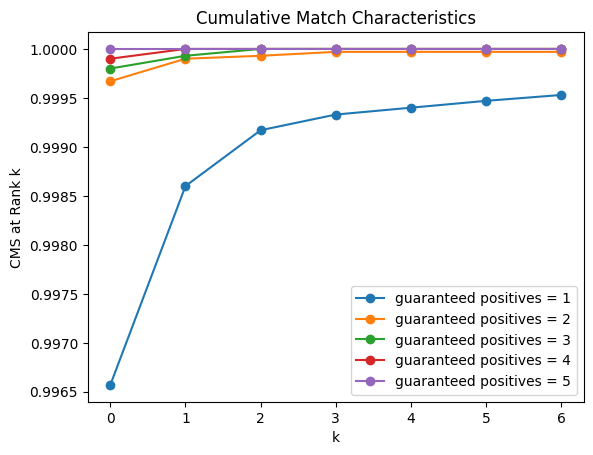

In [ ]:
# Sample data with labels
data_sets = [
    {'label': 'guaranteed positives = 1', 'data': [0.99657, 0.9986, 0.99917, 0.99933, 0.9994, 0.99947, 0.99953]},
    {'label': 'guaranteed positives = 2', 'data': [0.99967, 0.9999, 0.99993, 0.99997, 0.99997, 0.99997, 0.99997]},
    {'label': 'guaranteed positives = 3', 'data': [0.9998, 0.99993, 1.0, 1.0, 1.0, 1.0, 1.0]},
    {'label': 'guaranteed positives = 4', 'data': [0.9999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]},
    {'label': 'guaranteed positives = 5', 'data': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]},
]

# Create a line chart for each dataset
for dataset in data_sets:
    plt.plot(dataset['data'], marker='o', linestyle='-', label=dataset['label'])

# Add labels and title
plt.xlabel('k')
plt.ylabel('CMS at Rank k')
plt.title('Cumulative Match Characteristics')

# Add legend to the plot
plt.legend()

# Show the plot
plt.show()
